# I. Introduction

## A. Objective
The main objective of this analysis is to evaluate the performance of a NN in predicting the mortality rate based on various features and to understand the importance of each feature in the model.
This research is a part of a series of trials of different ML models.

## B. Dataset Description
The dataset consists of the following features:
1. Age
1. HBR (b)
1. Systolic AP(b)
1. Creatine in blood
1. EF Percentage
1. White blood cells count
1. Glucose
1. CHF KiLLip_1.0
1. CHF KiLLip_2.0
1. CHF KiLLip_3.0
1. CHF KiLLip_4.0

# II. Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_fscore_support,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier 
import shap


# III. Load Data

In [4]:
ready_data = pd.read_csv('./import/dataset_prepared_KiLLip_encoded.csv')

# IV. Splitting and processing the Data

## A. Splitting the dataset into features and the target.

In [5]:
X_global = ready_data.drop('Class', axis=1)
y_global = ready_data['Class']

### An additional split to hold out a test set

In [6]:
X_global_train, X_global_test, y_global_train, y_global_test = train_test_split(X_global, y_global, test_size=0.2, random_state=0, stratify=y_global)

## B. Standardize the data

In [7]:
scaler = StandardScaler()
X_global_train_scaled = scaler.fit_transform(X_global_train)
X_global_test_scaled = scaler.transform(X_global_test)

Convert scaled NumPy arrays back to Pandas DataFrames

In [8]:
X_global_train_scaled = pd.DataFrame(X_global_train_scaled, columns=X_global_train.columns)
X_global_test_scaled = pd.DataFrame(X_global_test_scaled, columns=X_global_test.columns)

We want to have more control over hyper parameters, so we examine three different random_state values. 

In [9]:
random_states = [0, 25, 42]

# V. Keras

## A. Initaial values

In [10]:
feature_names = ["Age", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", 
                 "White blood cells count", "Glucose", "CHF KiLLip_1.0", 
                 "CHF KiLLip_2.0", "CHF KiLLip_3.0", "CHF KiLLip_4.0"]

feature_importances = pd.DataFrame(index=feature_names)

best_score = 0  
best_params = {}
all_params = []

In [11]:
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units_input', min_value=6, max_value=16, step=2), 
#                     activation='relu', 
#                     input_dim=8))
#     model.add(Dense(1, activation='sigmoid'))

#     METRICS = [
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
#       tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

#     model.compile(optimizer=tf.keras.optimizers.Adam(
#                       learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#                   loss='binary_crossentropy', 
#                   metrics=METRICS)
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective=Objective('prc', direction='max'),
#     max_trials=5,
#     executions_per_trial=3,
#     directory='export',
#     project_name='keras_classification',
# )
# tuner.search_space_summary()
# tuner.search(X_resampled, y_resampled, epochs=10, validation_split=0.2, batch_size=100)
# Best params
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# print(f"""
# The hyperparameter search is complete. \nThe optimal number of units in the first densely-connected layer is {best_hps.get('units_input')},
# the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)
# best_model = tuner.get_best_models(num_models=1)[0]

## B. Define a function to calculate model's metrics.

In [12]:
def evaluate_model(y_test, y_predict_proba, threshold=0.5):
    """
    Evaluate a binary classification model using various metrics and plots.
    
    Parameters:
    -----------
    y_test : array-like of shape (n_samples,)
        True labels of the test set.
    y_predict_proba : array-like of shape (n_samples,)
        Probability estimates of the positive class.
    threshold : float, optional (default=0.5)
        Threshold for converting probability estimates to binary predictions.
    
    Returns:
    --------
    metrics : dict
        A dictionary containing the following metrics:
        - Precision
        - Recall
        - F1
        - F1_macro
        - ROC_AUC
        - PR_AUC
    
    Plots:
    ------
    - ROC curve
    - Precision-Recall curve
    """
    # Convert probability scores to binary predictions
    y_pred = (y_predict_proba >= threshold).astype(int)

    # 1. Precision, Recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # 2. F1-macro
    _, _, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    # 3. ROC-AUC
    roc_auc = roc_auc_score(y_test, y_predict_proba)


    # Create a figure to hold the subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # 4. Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")

    # 5. PR-AUC
    pr_auc = average_precision_score(y_test, y_predict_proba)

    # 6. Plot Precision-Recall curve
    precision_data, recall_data, _ = precision_recall_curve(y_test, y_predict_proba)
    axs[1].plot(recall_data, precision_data, color='b', alpha=0.2, label='PR curve (area = %0.2f)' % pr_auc)
    axs[1].fill_between(recall_data, precision_data, step='post', alpha=0.2, color='b')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_title('Precision-Recall curve')
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # Return metrics as a dictionary
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'F1_macro': f1_macro,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc
    }
    
    return metrics

## C. Define a Keras classifier model for grid search.

In [13]:
def build_model(units, learning_rate, input_dim):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=units, 
                                    activation='relu', 
                                    input_dim=input_dim))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy")
    return model

## D. Creating a grid with hyperparameters for grid search

In [14]:
hyperparameter_grid = {
    'batch_size':[100], # , 20, 50, 25, 32],  
    'epochs':[10], #, 200, 100, 300, 400], 
    'model__units':[6, 8, 10, 12, 14, 16],
    'model__learning_rate':[1e-2, 1e-3, 1e-4],
    'model__input_dim': [len(feature_names)]
}

## E. Choosing best parameters

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 1/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.857 total time=   3.9s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 2/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.866 total time=   1.6s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 3/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.886 total time=   2.2s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 4/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01,

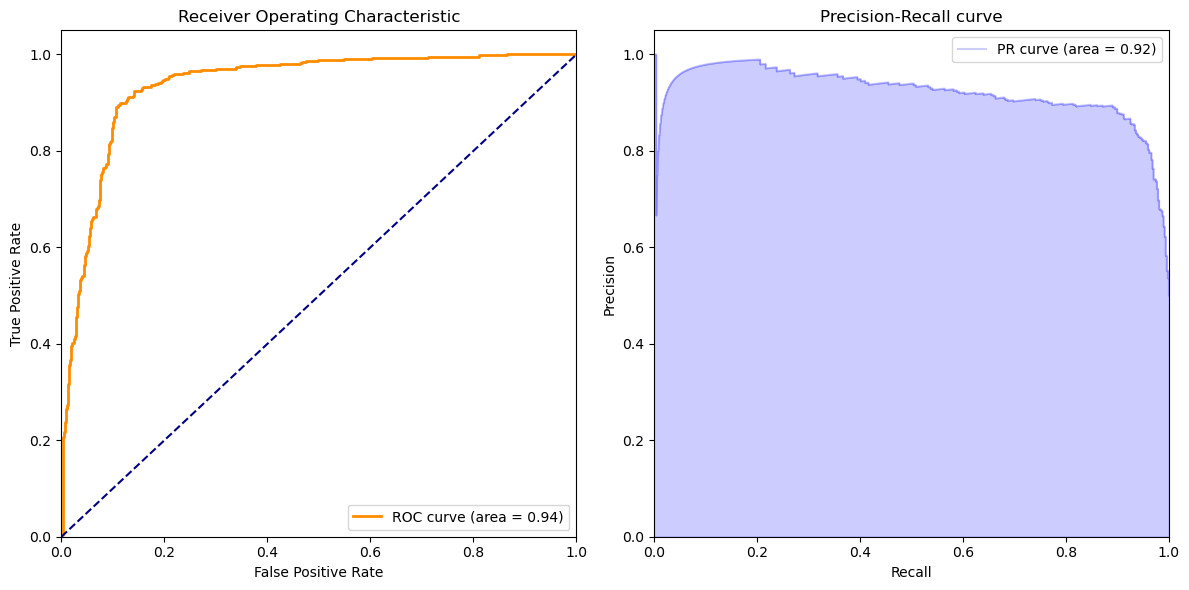

{'Precision': 0.5658536585365853,
 'Recall': 0.9957081545064378,
 'F1': 0.7216174183514773,
 'F1_macro': 0.5511201278608597,
 'ROC_AUC': 0.9374827313083682,
 'PR_AUC': 0.9220548304448302}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 1/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.873 total time=   1.7s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 2/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.628 total time=   1.5s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 3/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.653 total time=   1.9s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 4/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01,

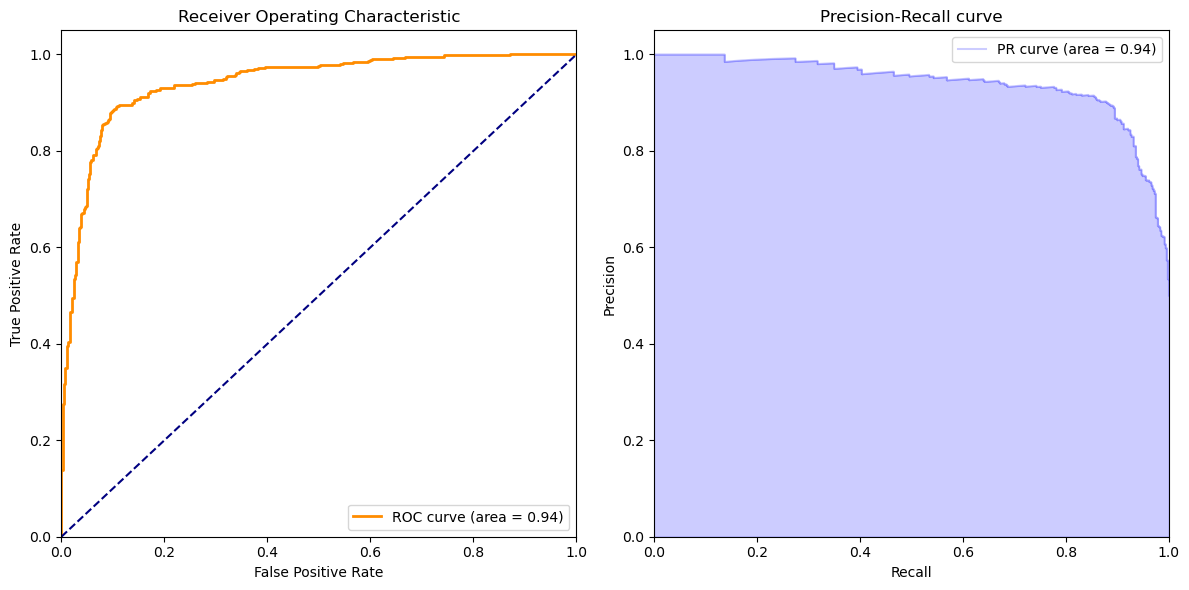

{'Precision': 0.5643203883495146,
 'Recall': 0.9978540772532188,
 'F1': 0.7209302325581396,
 'F1_macro': 0.5468762661048537,
 'ROC_AUC': 0.9415443275801729,
 'PR_AUC': 0.9403930590986045}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 1/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.345 total time=   2.1s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 2/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.332 total time=   1.2s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 3/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01, model__units=6;, score=0.336 total time=   1.3s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV 4/5] END batch_size=100, epochs=10, model__input_dim=11, model__learning_rate=0.01,

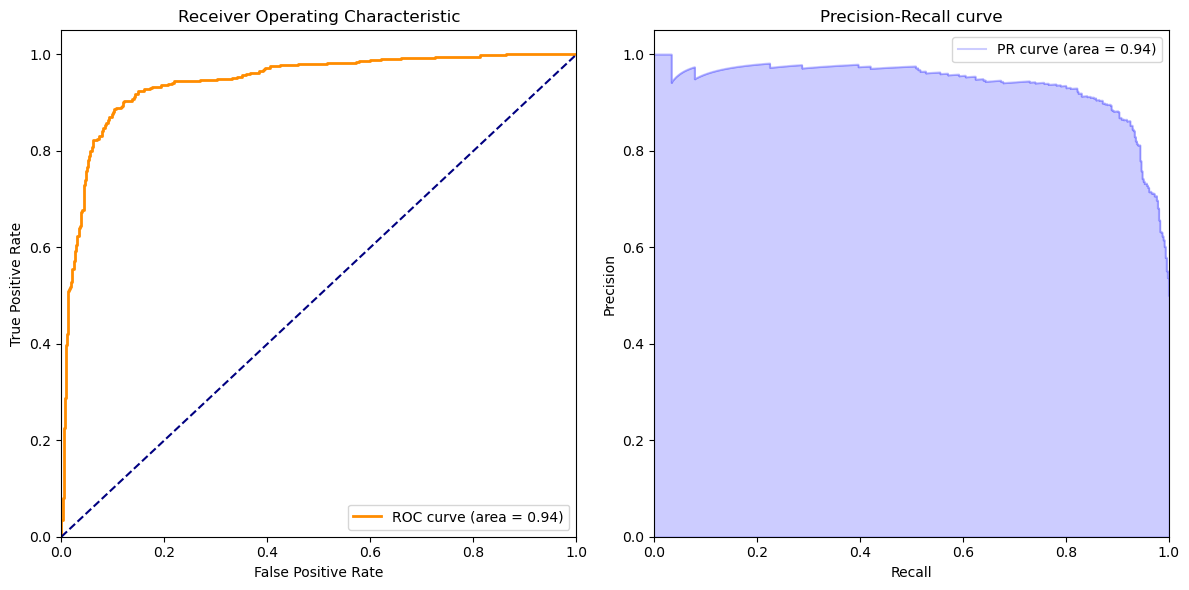

{'Precision': 0.6414565826330533,
 'Recall': 0.9828326180257511,
 'F1': 0.776271186440678,
 'F1_macro': 0.6951531370799882,
 'ROC_AUC': 0.9439941792996739,
 'PR_AUC': 0.9385408469048021}

,random_state,best_parameters,metrics
0,0,"{'batch_size': 100, 'epochs': 10, 'model__input_dim': 11, 'model__learning_rate': 0.01, 'model__units': 10}","{'Precision': 0.5658536585365853, 'Recall': 0.9957081545064378, 'F1': 0.7216174183514773, 'F1_macro': 0.5511201278608597, 'ROC_AUC': 0.9374827313083682, 'PR_AUC': 0.9220548304448302}"
1,25,"{'batch_size': 100, 'epochs': 10, 'model__input_dim': 11, 'model__learning_rate': 0.01, 'model__units': 10}","{'Precision': 0.5643203883495146, 'Recall': 0.9978540772532188, 'F1': 0.7209302325581396, 'F1_macro': 0.5468762661048537, 'ROC_AUC': 0.9415443275801729, 'PR_AUC': 0.9403930590986045}"
2,42,"{'batch_size': 100, 'epochs': 10, 'model__input_dim': 11, 'model__learning_rate': 0.01, 'model__units': 14}","{'Precision': 0.6414565826330533, 'Recall': 0.9828326180257511, 'F1': 0.776271186440678, 'F1_macro': 0.6951531370799882, 'ROC_AUC': 0.9439941792996739, 'PR_AUC': 0.9385408469048021}"


In [15]:
for random_state in random_states:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Resample
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_global_train, y_global_train)

    #Split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state, stratify=y_resampled)

    # Define model
    METRICS = [AUC, BinaryAccuracy]   
    model = KerasClassifier(model=build_model,
                            metrics=METRICS,
                            verbose=3,
                            random_state=random_state)

    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='f1_macro',
                           verbose=3)

    # Execute grid search
    grid_cv.fit(X_train, y_train)

    y_predict_proba = grid_cv.predict_proba(X_test)[:, 1]

    threshold = 0.05
    metrics = evaluate_model(y_test, y_predict_proba, threshold)
    display(metrics)


    if grid_cv.best_score_ > best_score:
        best_score = grid_cv.best_score_
        best_params = {
            'random_state': random_state,
            'batch_size': grid_cv.best_params_['batch_size'],
            'epochs': grid_cv.best_params_['epochs'],
            'model__learning_rate': grid_cv.best_params_['model__learning_rate'],
            'model__units': grid_cv.best_params_['model__units']
        }

    all_params_entry = {
        'random_state': random_state,
        'best_parameters': grid_cv.best_params_,
        'metrics': metrics
    }
    all_params.append(all_params_entry)

all_params_df = pd.DataFrame(all_params)
pd.set_option('display.max_colwidth', None)
display(all_params_df)

## D. Retrain the model with the best parameters on the whole dataset

In [16]:
final_model = build_model(units=best_params['model__units'],
                          learning_rate=best_params['model__learning_rate'],
                          input_dim=len(feature_names))

METRICS = [AUC, BinaryAccuracy]   

# Resample
smote = SMOTE(random_state=best_params['random_state'])
X_resampled, y_resampled = smote.fit_resample(X_global_train, y_global_train)

final_model.fit(X_resampled, y_resampled, 
                epochs=best_params['epochs'],
                batch_size=best_params['batch_size'],
                )

Epoch 1/10
47/47 [==============================] - 1s 2ms/step - loss: 3.3448
Epoch 2/10
47/47 [==============================] - 0s 3ms/step - loss: 0.5128
Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.4078
Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3589
Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3250
Epoch 7/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3012
Epoch 8/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3044
Epoch 9/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3274
Epoch 10/10
47/47 [==============================] - 0s 2ms/step - loss: 0.3142


## E. Evaluate final model

19/19 [==============================] - 0s 1ms/step


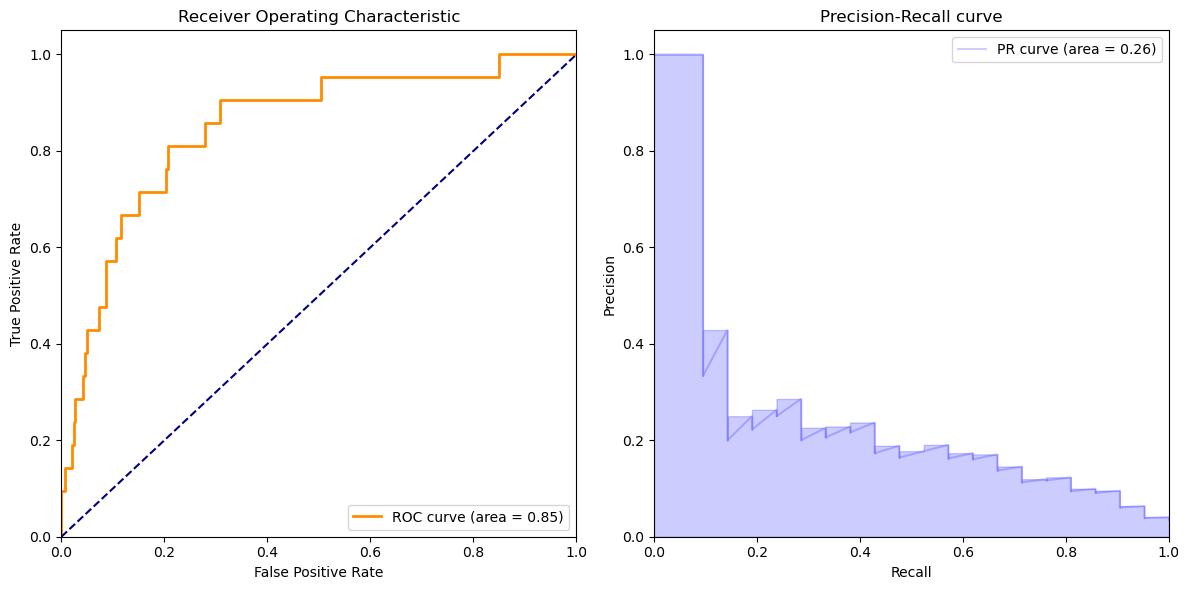

{'Precision': 0.07883817427385892,
 'Recall': 0.9047619047619048,
 'F1': 0.1450381679389313,
 'F1_macro': 0.45412584929716127,
 'ROC_AUC': 0.8481581311769991,
 'PR_AUC': 0.26223060605869625}

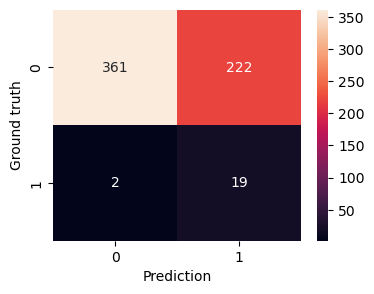

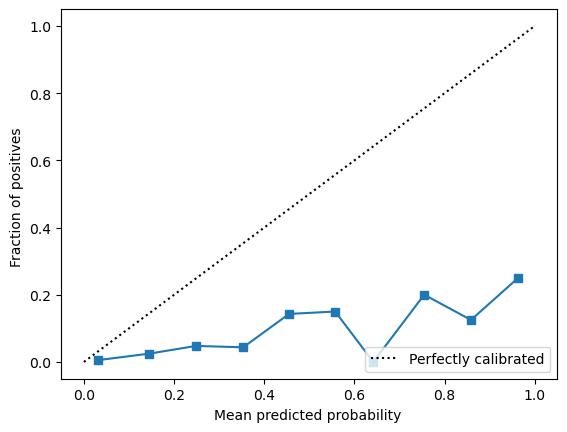

In [17]:
# y_pred_proba = final_model.predict_proba(X_global_test, verbose=1)[:, 1]
y_pred_proba = final_model.predict(X_global_test, verbose=1)
threshold=0.09

metrics = evaluate_model(y_global_test, y_pred_proba, threshold)
display(metrics)

y_pred = (y_pred_proba >= threshold).astype(int)
cm = confusion_matrix(y_global_test, y_pred)
plt.figure(figsize = (4, 3))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Ground truth')
plt.xlabel('Prediction');

from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_global_test, y_pred_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_global_test)
disp.plot()

### Probability distribution

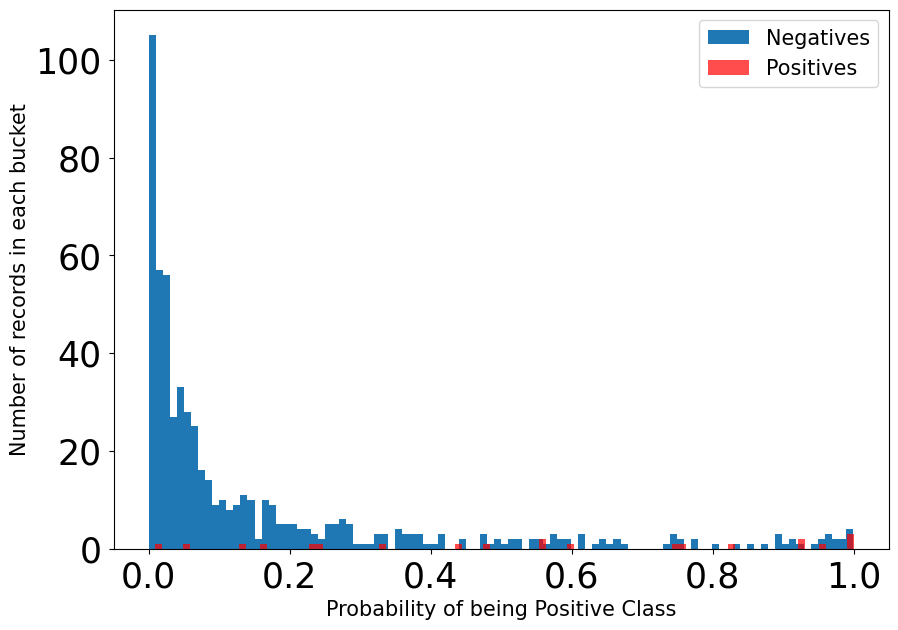

In [18]:
plt.figure(figsize=(10,7))
plt.hist(y_pred_proba[y_global_test==0], bins=100, label='Negatives')
plt.hist(y_pred_proba[y_global_test==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=15)
plt.ylabel('Number of records in each bucket', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

### 1. SHAP Values

In [19]:
final_model

In [20]:
# select a set of background examples to take an expectation over
#background = shap.maskers.Independent(X_resampled, max_samples=1000)
background = shap.sample(X_resampled, 100, random_state=best_params['random_state'])
explainer = shap.GradientExplainer(final_model, X_resampled)
shap_values = explainer.shap_values(X_global_test.values)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [21]:
feature_importances["Mean shap values"] = np.mean(np.abs(shap_values), axis=0)
feature_importances

ValueError: Length of values (604) does not match length of index (11)

### 3. Plotting features' weights and coefficients

In [ ]:
def plot_weights(feature_importances, column1, column2, label1, label2, title, num_digits=3):
    plt.style.use('seaborn-v0_8-talk')  # Applying the style
    palette = sns.color_palette("husl", 2)  # Defining the color palette
    
    barWidth = 0.45

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create 1 row, 2 columns of subplots

    def add_values(ax, bars):
        for bar in bars:
            width = bar.get_width()
            if width >= 0:
                h_align = 'left'  # Horizontal alignment
                padding = 0.001  # Adjust this value to position the text to the right of the bar
            else:
                h_align = 'right' 
                padding = -0.000001  # Adjust this value to position the text to the left of the bar

            ax.text(width + padding,               
                    bar.get_y() + bar.get_height() / 2.5 ,  
                    f"{width :.{num_digits}f}",  
                    ha=h_align, va='center', fontsize=7)

    # Plot for column 1
    bars1 = axs[0].barh(r1, feature_importances[column1], color=palette[0], height=barWidth, edgecolor='grey', label=label1)
    axs[0].set_yticks(r1)
    axs[0].set_yticklabels(feature_importances.index, fontsize=10)
    axs[0].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)
    axs[0].legend()
    add_values(axs[0], bars1)  # Add values to the bars in the first subplot

    # Plot for column 2
    bars2 = axs[1].barh(r2, feature_importances[column2], color=palette[1], height=barWidth, edgecolor='grey', label=label2)
    axs[1].set_yticks(r2)
    axs[1].set_yticklabels(feature_importances.index, fontsize=10)
    axs[1].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[1].grid(axis='x', linestyle='--', alpha=0.7)
    axs[1].legend()
    add_values(axs[1], bars2)  # Add values to the bars in the second subplot

    # Set a common title
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top to make room for the suptitle

    plt.show()

In [ ]:
plot_weights(feature_importances, 
             column1=None, 
             column1='Mean shap values', 
             label1='Importance', 
             label2='Mean shap values', 
             title='Shap values and Importance \n Keras Classifier',
             num_digits=3)

In [ ]:
shap.summary_plot(shap_values[0], X_test, feature_names=feature_names, plot_type='violin')

